In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from rl_analysis.plotting import setup_plotting_env, savefig
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import seaborn as sns

In [3]:
import toml

with open("../analysis_configuration.toml", "r") as f:
    analysis_config = toml.load(f)

In [4]:
raw_dirs = analysis_config["raw_data"]
proc_dirs = analysis_config["intermediate_results"]
lagged_cfg = analysis_config["dlight_lagged_correlations"]
figure_cfg = analysis_config["figures"]

In [5]:
# DON'T FORGOT TO ENSURE THIS IS OFFLINE!
file_suffix = "offline" if lagged_cfg["use_offline"] else "online"
load_file = os.path.join(proc_dirs["dlight"], f"dlight_snippets_{file_suffix}.parquet")

In [6]:
file, ext = os.path.splitext(load_file)
features_save_file = f"{file}_features{ext}"

if lagged_cfg["use_renormalized"]:
    file, ext = os.path.splitext(features_save_file)
    features_save_file = f"{file}_renormalize{ext}"

rle_save_file = features_save_file.replace("snippet", "usage")
file, ext = os.path.splitext(features_save_file)
file = f"{file}_for_examples"

results_file = f"{file}_lag_usage_and_scalars.parquet"
results_tm_file = f"{file}_lag_usage_and_scalars.npy"
corr_file = f"{file}_lag_usage_and_scalars_correlations.parquet"
shuffle_file = f"{file}_lag_usage_and_scalars_shuffle.parquet"

In [7]:
use_features = []
for _use_win in lagged_cfg["use_windows"]:
    use_features += [f"{_}_{_use_win}" for _ in lagged_cfg["use_neural_features"]]
scalar_keys = lagged_cfg["usage_and_scalars"]["scalars"]

# Find some good examples for plotting

In [8]:
syllable_rates = pd.read_parquet(results_file)

In [9]:
syllable_rates = syllable_rates.loc[
    ~syllable_rates["mouse_id"].str.contains("dms")
].copy()

In [10]:
plt_feature = "signal_reref_dff_z_max_(0.0, 0.3)"

In [11]:
snippet_df = pd.read_parquet(
    os.path.join(raw_dirs["dlight"], "dlight_snippets_offline.parquet"),
    columns=["uuid", "snippet", "signal_reref_dff_z", "x", "timestamp"],
)

In [12]:
use_feature = plt_feature

In [13]:
plt_syllable_rates = syllable_rates

In [14]:
plt_syllable_rates["dlight"] = plt_syllable_rates[use_feature]
plt_syllable_rates = plt_syllable_rates.dropna(subset=["dlight"])

bins = 4
dlight_bin = (
    plt_syllable_rates.groupby(["mouse_id", "syllable"])["dlight"]
    .transform(lambda x: pd.qcut(x, bins, labels=False, duplicates="drop"))
)

plt_syllable_rates["dlight_bin"] = dlight_bin.astype("UInt8")
plt_syllable_rates = plt_syllable_rates.dropna(subset=["dlight_bin"])

/tmp/ipykernel_1343754/930767883.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plt_syllable_rates["dlight_bin"] = dlight_bin.astype("UInt8")


In [15]:
# show bins
show_bins = [0, 4]

In [16]:
uniq_bins = sorted(dlight_bin.dropna().unique())

In [17]:
show_bins = [
    uniq_bins[0],
    uniq_bins[1 * len(uniq_bins) // 4],
    uniq_bins[3 * len(uniq_bins) // 4 - 1],
    uniq_bins[-1],
]

In [18]:
syllable_rate_idx = (
    plt_syllable_rates.reset_index()
    .set_index(["syllable", "uuid", "dlight_bin"])
    .sort_index()
)

In [19]:
group_keys = ["syllable", "uuid", "bin"]
ave_rates = plt_syllable_rates.groupby(group_keys + ["dlight_bin"]).mean()

/tmp/ipykernel_1343754/3857727481.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ave_rates = plt_syllable_rates.groupby(group_keys + ["dlight_bin"]).mean()


In [20]:
mu = ave_rates.groupby(group_keys).mean()
sig = ave_rates.groupby(group_keys).std()

In [21]:
ave_rates["pseudocount"] = ave_rates["count"] + 0
mu["pseudocount"] = mu["count"] + 0

In [22]:
use_stat = "fold"

if use_stat == "diff":
    usage_diffs = (ave_rates - mu).sort_index()
    scalar_diffs = (ave_rates - mu).sort_index()

elif use_stat == "fold":
    usage_diffs = np.log2((ave_rates / mu)).sort_index()
    scalar_diffs = (ave_rates - mu).sort_index()



/home/markowitzmeister_gmail_com/miniconda3/envs/spont-da/lib/python3.10/site-packages/pandas/core/internals/blocks.py:352: RuntimeWarning: divide by zero encountered in log2
  result = func(self.values, **kwargs)
/home/markowitzmeister_gmail_com/miniconda3/envs/spont-da/lib/python3.10/site-packages/pandas/core/internals/blocks.py:352: RuntimeWarning: invalid value encountered in log2
  result = func(self.values, **kwargs)


In [23]:
plt_variables = [
    "pseudocount",
    "velocity_2d_mm_global_bin",
]

In [24]:
idx = pd.IndexSlice

In [25]:
from cycler import cycler

In [26]:
from rl_analysis.plotting import clean_ticks

In [27]:
n = 100
sns.set_context("paper")
pal = sns.color_palette("Blues", n_colors=len(show_bins) + 1)[1:]
dlight_pal = sns.color_palette("Greens", n_colors=len(show_bins) + 1)[1:]
custom_cycler = cycler(color=pal)
dlight_custom_cycler = cycler(color=dlight_pal)

In [28]:
setup_plotting_env()

In [29]:
aliases = {
    "pseudocount": "de-meaned counts",
    "velocity_2d_mm_global_bin": "de-meaned vel.",
}

In [30]:
dlight_rolling_kwargs = {"window": 5, "min_periods": 1, "center": True}

In [31]:
smooth_kwargs = {"window": 3, "min_periods": 1, "center": True}

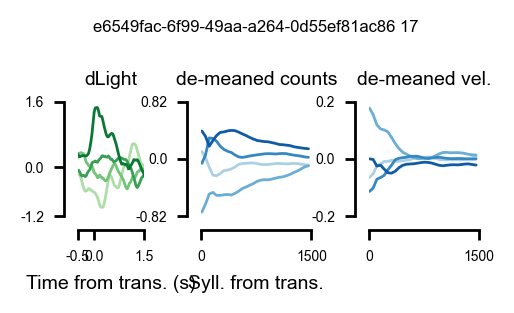

In [32]:
syllable = 17
uuid = "e6549fac-6f99-49aa-a264-0d55ef81ac86"
fig, ax = plt.subplots(
    1,
    len(plt_variables) + 1,
    figsize=(2.6, 1.5),
    sharex=False,
    sharey=False,
    gridspec_kw={"width_ratios": [1.2, 2, 2]},
)

ax[0].set_prop_cycle(dlight_custom_cycler)
for _ax in ax[1:]:
    _ax.set_prop_cycle(custom_cycler)

use_diffs = usage_diffs.xs(uuid, level="uuid")
use_scalar_diffs = scalar_diffs.xs(uuid, level="uuid")

show_levels = sorted(
    use_diffs.xs(syllable, level="syllable").index.get_level_values(-1).unique()
)
show_levels = show_bins

for _level in show_levels:
    try:
        use_snippets = syllable_rate_idx.xs(
            (syllable, uuid, _level), level=("syllable", "uuid", "dlight_bin")
        )["snippet"].tolist()
    except KeyError:
        continue
    activity_trace = (
        (
            snippet_df[snippet_df["snippet"].isin(use_snippets)]
            .groupby("x")["signal_reref_dff_z"]
            .mean()
        )
        .rolling(**dlight_rolling_kwargs)
        .mean()
    )
    # ADD SMOOTHING HERE
    activity_trace.plot(ax=ax[0])

for _variable, _ax in zip(plt_variables, ax[1:]):
    if "count" in _variable:
        plt_data = (
            use_diffs.loc[idx[syllable, :, show_levels], _variable]
            .unstack()
            .rolling(**smooth_kwargs)
            .mean()
        )
    else:
        plt_data = (
            use_scalar_diffs.loc[idx[syllable, :, show_levels], _variable]
            .unstack()
            .rolling(**smooth_kwargs)
            .mean()
        )
    plt_x = plt_data.index.get_level_values("bin")
    plt_y = plt_data.values
    h = _ax.plot(plt_x, plt_y)
    _ax.set_title(aliases[_variable])

sns.despine(offset=5)
ax[1].set_xlim(0, 1500)
ax[2].set_xlim(0, 1500)
# ax[1].set_xlim(0, 1000)
# ax[2].set_xlim(0, 1000)

ax[0].set_title("dLight")
ax[0].set_xlabel("Time from trans. (s)")
ax[1].set_xlabel("Syll. from trans.")

fig.suptitle(f"{uuid} {syllable}", fontsize=6)
fig.tight_layout()
fig.subplots_adjust(wspace=0.6)

for _ax in ax:
    #         clean_ticks(_ax, "y", precision=1, zero_symmetry=True, dtype=float)
    clean_ticks(_ax, "x", precision=0, zero_symmetry=True, dtype=int)

ax[0].set_xlim(-0.5, 1.5)
clean_ticks(ax[0], "x", precision=1, zero_symmetry=False, dtype=float)
clean_ticks(ax[0], "y", precision=1, zero_symmetry=False, dtype=float)
clean_ticks(ax[1], "y", precision=2, zero_symmetry=True, dtype=float)
clean_ticks(ax[2], "y", precision=2, zero_symmetry=True, dtype=float)
#     for _ax in ax[:2]:
#         clean_ticks(_ax, "y", precision=1, zero_symmetry=True, dtype=int)

plt.show()
savefig(
    fig,
    os.path.join(
        figure_cfg["store_dir"],
        "usage_correlation_examples",
        f"correlation_decay_analysis_example_{uuid}-{syllable}-{use_stat}",
    ),
    bbox_inches="tight",
)